In [1]:
from tectosaur2.nb_config import setup
setup()

## Setup geometry

In [2]:
import cutde.fullspace as FS
import cutde.halfspace as HS
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import gauss_rule, refine_surfaces, integrate_term, tensor_dot
from tectosaur2.laplace2d import double_layer, hypersingular
from tectosaur2.mesh import panelize_symbolic_surface

In [3]:
from tectosaur2.mesh import pts_grid
nobs = 50
zoomx = [-1, 2]
zoomy = [-3, 0]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)
obsx = obs_pts[:, 0]
obsy = obs_pts[:, 1]

In [4]:
surf_half_L = 10
fault_bottom = 1
qx, qw = gauss_rule(5)
edges = np.linspace(-1, 1, 41)
panel_bounds = np.stack((edges[:-1],edges[1:]), axis=1)
angle_rad = sp.pi / 6
fault_length = 1
sp_t = sp.var("t")
sp_x = (sp_t + 1) / 2 * sp.cos(angle_rad) * fault_length
sp_y = -(sp_t + 1) / 2 * sp.sin(angle_rad) * fault_length
fault = panelize_symbolic_surface(
    sp_t, sp_x, sp_y,
    panel_bounds,
    qx, qw
)

free = refine_surfaces(
    [
        (sp_t, -sp_t * surf_half_L, 0 * sp_t)  # free surface
    ],
    (qx, qw),
    control_points = [(0, 0, 1.5, 0.3)]
)
print(
    f"The free surface mesh has {free.n_panels} panels with a total of {free.n_pts} points."
)
print(
    f"The fault mesh has {fault.n_panels} panels with a total of {fault.n_pts} points."
)

The free surface mesh has 38 panels with a total of 190 points.
The fault mesh has 40 panels with a total of 200 points.


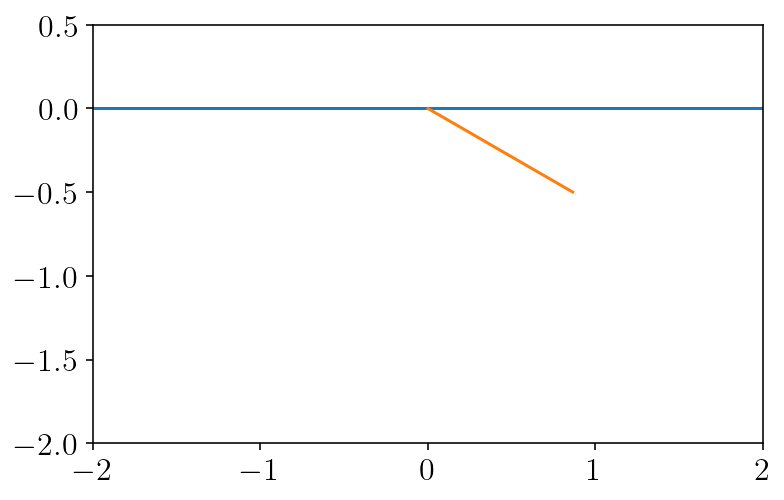

In [5]:
plt.plot(free.pts[:,0], free.pts[:,1])
plt.plot(fault.pts[:,0], fault.pts[:,1])
plt.axis('scaled')
plt.xlim([-2, 2])
plt.ylim([-2, 0.5])
plt.show()


## Compute BIE operators

In [6]:
from tectosaur2.elastic2d import elastic_t, elastic_h

singularities = [
    (0, -1),
    (0, 0),
    (-surf_half_L, 0),
    (surf_half_L, 0)
]
(free_disp_to_free_disp, fault_slip_to_free_disp), report = integrate_term(
    elastic_t(0.25),
    free.pts,
    free,
    fault,
    tol=1e-10,
    safety_mode=True,
    singularities=singularities,
    return_report=True,
)

(free_disp_to_obs_disp, fault_slip_to_obs_disp), report = integrate_term(
    elastic_t(0.25),
    obs_pts,
    free,
    fault,
    tol=1e-10,
    safety_mode=True,
    singularities=singularities,
    return_report=True,
)

(free_disp_to_obs_stress, fault_slip_to_obs_stress), report = integrate_term(
    elastic_h(0.25),
    obs_pts,
    free,
    fault,
    tol=1e-10,
    safety_mode=True,
    singularities=singularities,
    return_report=True,
)


/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:180: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(
/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:174: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(


## Run TDE calculations

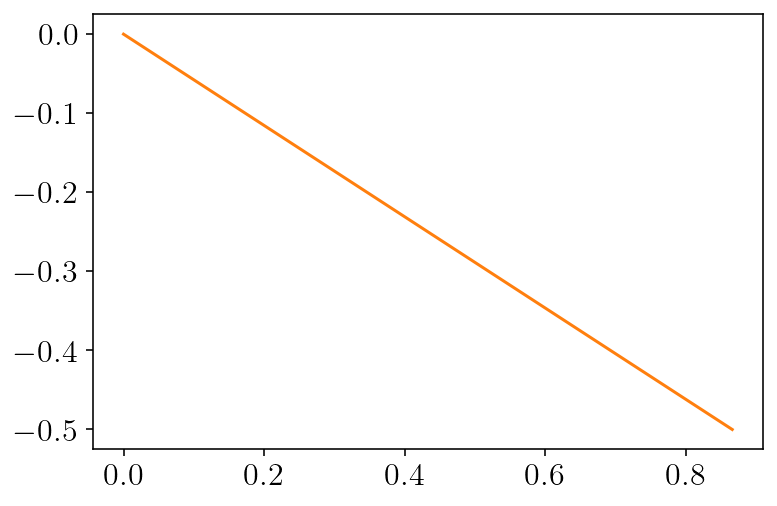

In [7]:
ZL = 500
obs_pts3d = np.zeros((obs_pts.shape[0], 3))
obs_pts3d[:,:2] = obs_pts

x_bottom = float(sp_x.subs(sp_t, 1))
y_bottom = float(sp_y.subs(sp_t, 1))
tris = np.array([
    [[0,0,-ZL],[0,0,ZL],[x_bottom,y_bottom,ZL]],
    [[0,0,-ZL],[x_bottom,y_bottom,ZL],[x_bottom,y_bottom,-ZL]],
])
plt.plot(tris[:,:,0], tris[:,:,1])
plt.show()

In [8]:
slip_tde = np.array([[1.0,0.0,0.0]] * 2)
slip_tde.shape
fs_strain_mat = FS.strain_matrix(obs_pts3d, tris, 0.25)
fs_strain_cutde = tensor_dot(fs_strain_mat, slip_tde)
fs_stress_cutde3d = FS.strain_to_stress(fs_strain_cutde, 1.0, 0.25)
fs_stress_cutde = fs_stress_cutde3d[:,[0,1,3]]

fs_disp_mat = FS.disp_matrix(obs_pts3d, tris, 0.25)
fs_disp_cutde3d = tensor_dot(fs_disp_mat, slip_tde)
fs_disp_cutde = tensor_dot(fs_disp_mat, slip_tde)[:,[0,1]]

hs_strain_mat = HS.strain_matrix(obs_pts3d, tris, 0.25)
hs_strain_cutde = tensor_dot(hs_strain_mat, slip_tde)
hs_stress_cutde3d = HS.strain_to_stress(hs_strain_cutde, 1.0, 0.25)
hs_stress_cutde = fs_stress_cutde3d[:,[0,1,3]]

hs_disp_mat = HS.disp_matrix(obs_pts3d, tris, 0.25)
hs_disp_cutde3d = tensor_dot(hs_disp_mat, slip_tde)
hs_disp_cutde = tensor_dot(hs_disp_mat, slip_tde)[:,[0,1]]

## Check fullspace stress

In [11]:
nx = fault.normals[:, 0]
ny = fault.normals[:, 1]
slip = np.stack((-ny, nx), axis=1)
fs_stress_tct2 = -tensor_dot(fault_slip_to_obs_stress, slip)
fs_disp_tct2 = -tensor_dot(fault_slip_to_obs_disp, slip)

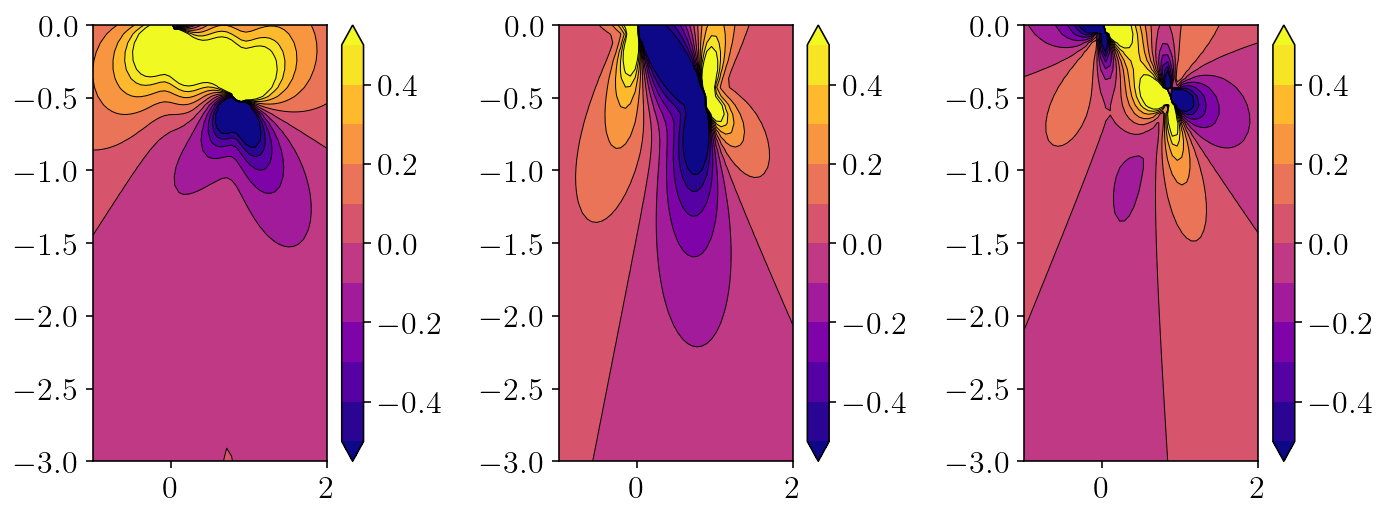

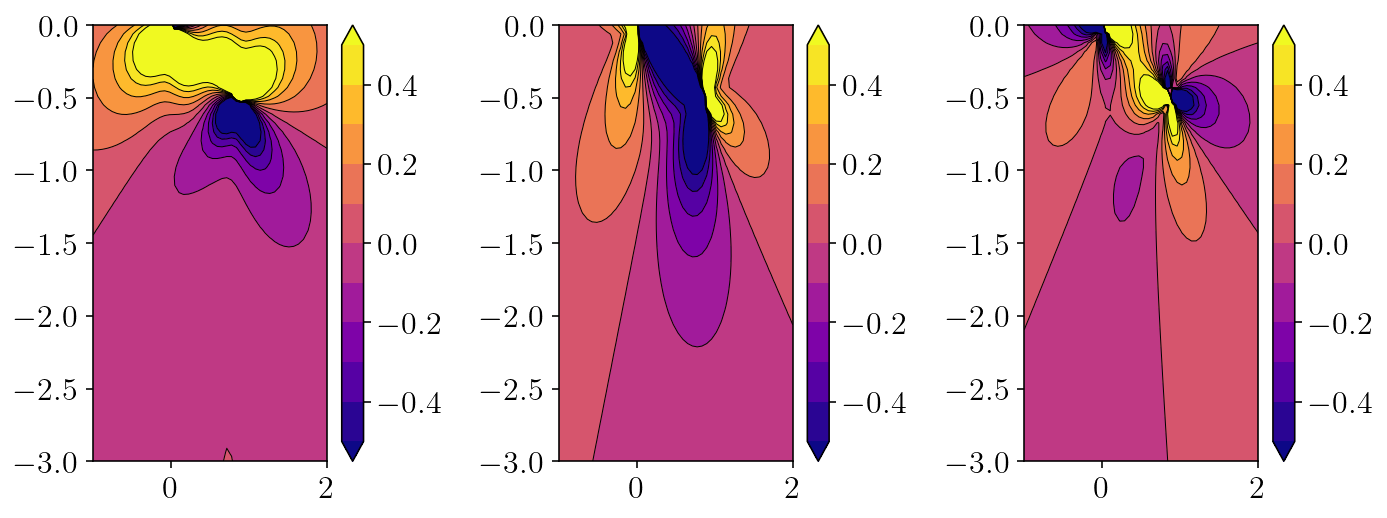

-6.939258121167644 -5.735593426621397
-7.901133985009631 -6.196901275445632
-8.447743497479482 -6.216095877253147


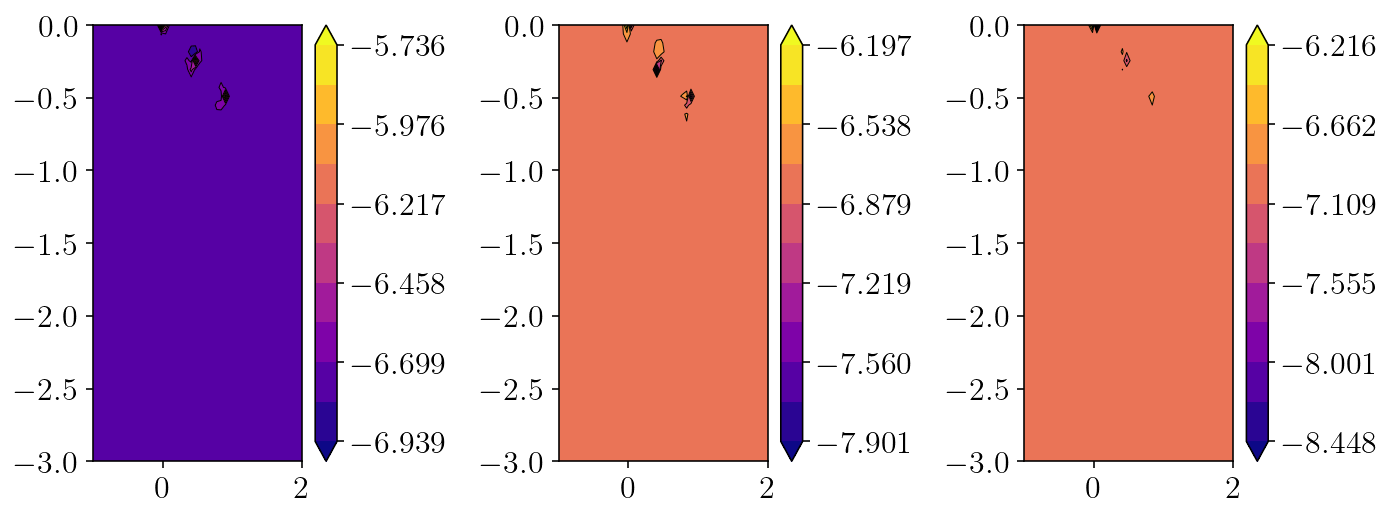

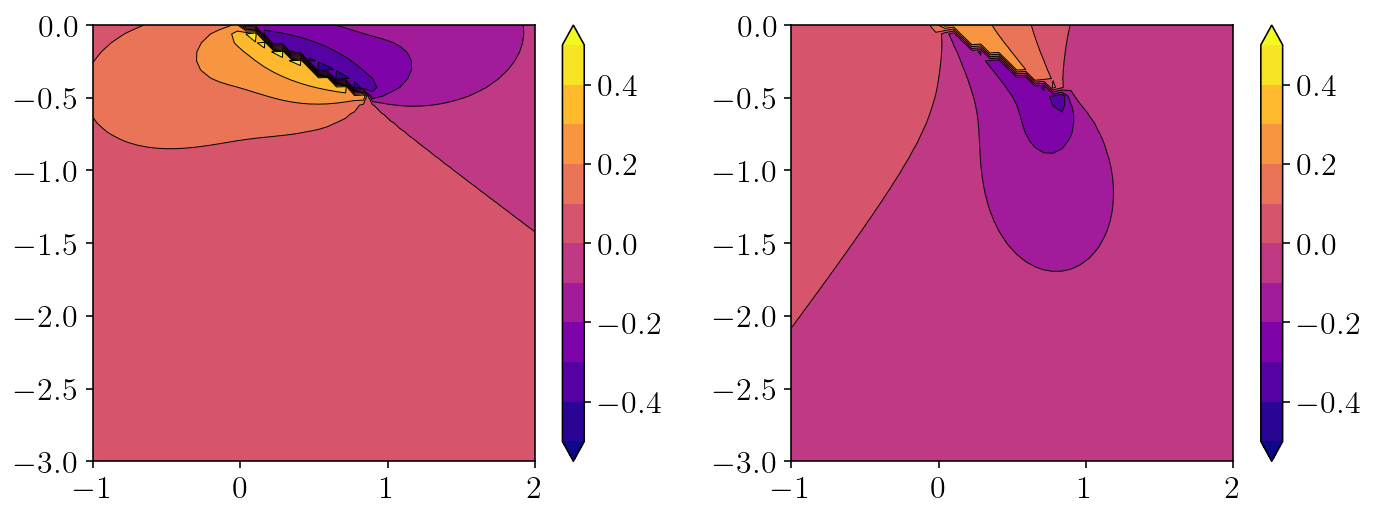

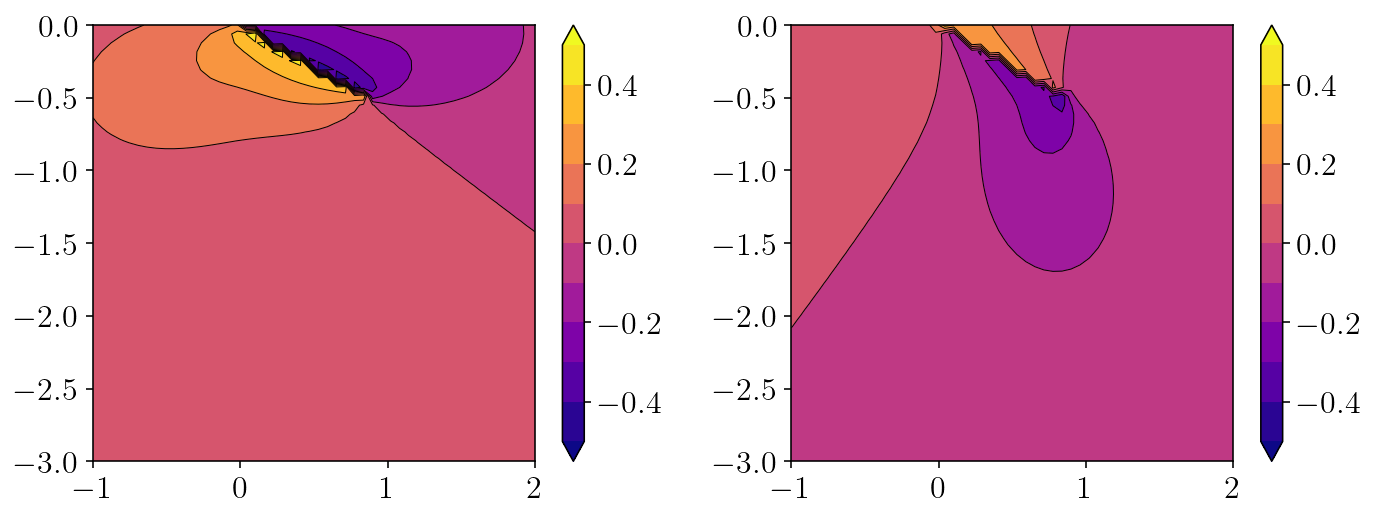

-10.186020688962746 -6.556641324534875
-10.436815088771382 -6.473882772593988


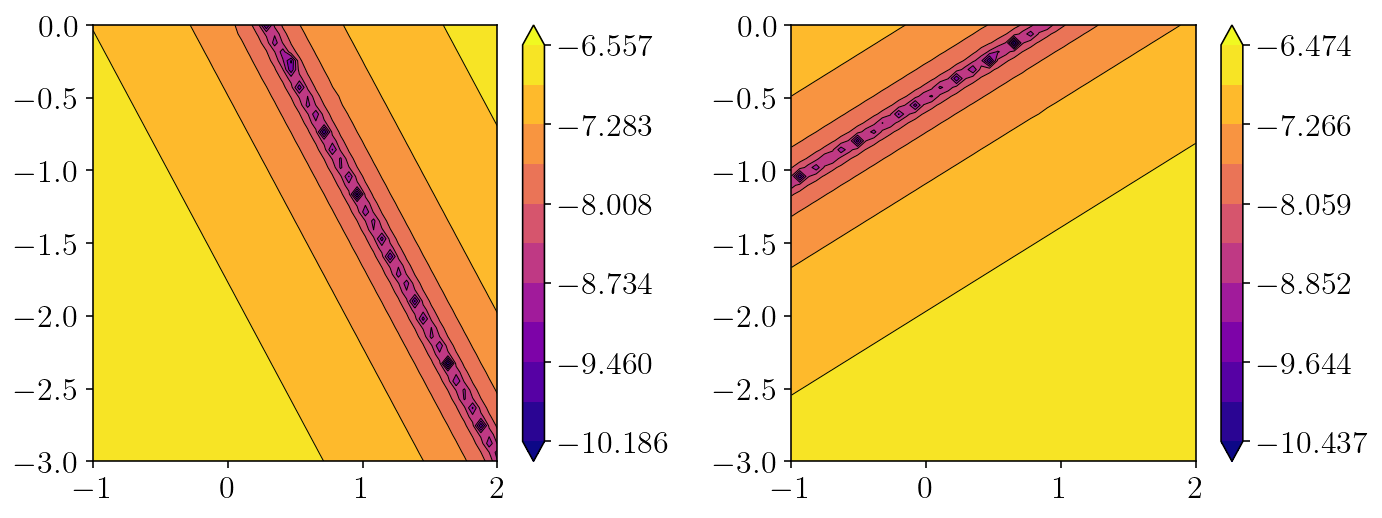

In [12]:
xs = obs_pts[:,0].reshape((nobs, nobs))
ys = obs_pts[:,1].reshape((nobs, nobs))

for va, vb in [(fs_stress_cutde, fs_stress_tct2), (fs_disp_cutde, fs_disp_tct2)]:
    nd = va.shape[1]
    for v in [va, vb]:
        plt.figure(figsize=(10,4))
        for i in range(nd):
            plt.subplot(1,nd,1+i)
            v2d = v[:, i].reshape((nobs, nobs))
            levels = np.linspace(-0.5,0.5,11)
            cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
            plt.contour(
                xs,
                ys,
                v2d,
                colors="k",
                linestyles="-",
                linewidths=0.5,
                levels=levels,
                extend="both",
            )
            plt.colorbar(cntf)
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(10,4))
    for i in range(nd):
        plt.subplot(1,nd,1+i)
        v2d = np.log10(np.abs(va-vb))[:,i].reshape((nobs, nobs))
        print(np.min(v2d), np.max(v2d))
        levels = np.linspace(np.min(v2d),np.max(v2d),11)
        cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
        plt.contour(
            xs,
            ys,
            v2d,
            colors="k",
            linestyles="-",
            linewidths=0.5,
            levels=levels,
            extend="both",
        )
        plt.colorbar(cntf)
    plt.tight_layout()
    plt.show()

In [5]:

import sympy as sp
import numpy as np
from tectosaur2 import refine_surfaces, gauss_rule, integrate_term
from tectosaur2.elastic2d import ElasticU, ElasticA
t=sp.var('t')
line = refine_surfaces(
    [(t, -1 * t, 0.0 * t)],
    gauss_rule(10),
    control_points=np.array([[0, 0, 100, 0.1]]),
)
delta = 0.001
obs_pt = np.array([[1.5, -1.5]])
obs_pts_fd = np.array(
    [
        [obs_pt[0, 0] - delta, obs_pt[0, 1]],
        [obs_pt[0, 0] + delta, obs_pt[0, 1]],
        [obs_pt[0, 0], obs_pt[0, 1] - delta],
        [obs_pt[0, 0], obs_pt[0, 1] + delta],
    ]
)

nu = 0.25
mu = 1.0
lam = 2 * mu * nu / (1 - 2 * nu)
K_base, K_deriv = ElasticU, ElasticA
print(K_base)
I = integrate_term(K_base(nu), obs_pts_fd, line)
vs = I[:, :, :, 0].sum(axis=2)

dux_dx = (vs[1, 0] - vs[0, 0]) / (2 * delta)
duy_dx = (vs[1, 1] - vs[0, 1]) / (2 * delta)
dux_dy = (vs[3, 0] - vs[2, 0]) / (2 * delta)
duy_dy = (vs[3, 1] - vs[2, 1]) / (2 * delta)

exx = dux_dx
eyy = duy_dy
exy = 0.5 * (dux_dy + duy_dx)

trace_e = exx + eyy
sxx = 2 * exx + lam * trace_e
syy = 2 * eyy + lam * trace_e
sxy = 2 * exy

Id = integrate_term(K_deriv(nu), obs_pt, line)
deriv_vs = Id[0, :, :, 0].sum(axis=1)
np.testing.assert_allclose(deriv_vs, [sxx, syy, sxy], atol=1e-3)

<class 'tectosaur2.elastic2d.ElasticU'>
[-0.09490146 -0.03494515  0.09780209]


In [6]:
exx, eyy, exy

(-0.031219901596303556, -0.0012417431159844616, 0.04890103961560817)

In [7]:
sxx, syy, sxy

(-0.09490144790489513, -0.03494513094425694, 0.09780207923121634)